## Importing libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import json
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Preprocessing the Data

In [2]:
#Getting the data from the wikipedia page 
Neighborhoods = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
Neighborhoods

[    Postal Code           Borough  \
 0           M1A      Not assigned   
 1           M2A      Not assigned   
 2           M3A        North York   
 3           M4A        North York   
 4           M5A  Downtown Toronto   
 5           M6A        North York   
 6           M7A  Downtown Toronto   
 7           M8A      Not assigned   
 8           M9A         Etobicoke   
 9           M1B       Scarborough   
 10          M2B      Not assigned   
 11          M3B        North York   
 12          M4B         East York   
 13          M5B  Downtown Toronto   
 14          M6B        North York   
 15          M7B      Not assigned   
 16          M8B      Not assigned   
 17          M9B         Etobicoke   
 18          M1C       Scarborough   
 19          M2C      Not assigned   
 20          M3C        North York   
 21          M4C         East York   
 22          M5C  Downtown Toronto   
 23          M6C              York   
 24          M7C      Not assigned   
 25         

In [3]:
#choosing the first table that has the needed data 
Neighborhoods=Neighborhoods[0]

In [4]:
Neighborhoods.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [5]:
#dropping rows with no Borough name
Neighborhoods = Neighborhoods[Neighborhoods['Borough'] != 'Not assigned'].reset_index(drop=True)

In [6]:
Neighborhoods.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [7]:
Neighborhoods.shape

(103, 3)

In [8]:
#getting location data 
Latlong=pd.read_csv('http://cocl.us/Geospatial_data')
Latlong.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
#adding latitude and longitude columns to the data frame
Latitude=[""]*103
Longitude=[""]*103

In [10]:
Neighborhoods["Latitude"]=Latitude
Neighborhoods["Longitude"]=Longitude
Neighborhoods.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,,
1,M4A,North York,Victoria Village,,
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",,
3,M6A,North York,"Lawrence Manor, Lawrence Heights",,
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",,


In [11]:
for k in Neighborhoods['Postal Code']:
        Neighborhoods.loc[Neighborhoods["Postal Code"] == k,"Latitude"]=float(Latlong.loc[Latlong['Postal Code'] == k]['Latitude'])
        Neighborhoods.loc[Neighborhoods["Postal Code"] == k,"Longitude"]=float(Latlong.loc[Latlong['Postal Code'] == k]['Longitude'])
Neighborhoods.head()


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7533,-79.3297
1,M4A,North York,Victoria Village,43.7259,-79.3156
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6543,-79.3606
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7185,-79.4648
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6623,-79.3895


## Visualizations using maps

In [12]:
address = 'Toronto'

geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 43.6534817, -79.3839347.


In [13]:
# create map of New York using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Neighborhoods['Latitude'], Neighborhoods['Longitude'], Neighborhoods['Borough'], Neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

In [14]:
# filter borough names that contain the word Toronto
borough_names = list(Neighborhoods.Borough.unique())

New_borough = []

for x in borough_names:
    if "toronto" in x.lower():
        New_borough.append(x)
        
New_borough

['Downtown Toronto', 'East Toronto', 'West Toronto', 'Central Toronto']

In [15]:
# create a new DataFrame with only boroughs that contain the word Toronto
toronto_new = Neighborhoods[Neighborhoods['Borough'].isin(New_borough)].reset_index(drop=True)
print(toronto_new.shape)
toronto_new.head()

(39, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6543,-79.3606
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6623,-79.3895
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3789
3,M5C,Downtown Toronto,St. James Town,43.6515,-79.3754
4,M4E,East Toronto,The Beaches,43.6764,-79.293


In [16]:
# create map of toronto with borough withe "toronto" in their name
m_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_new['Latitude'], toronto_new['Longitude'], toronto_new['Borough'], toronto_new['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(m_toronto)  
    
m_toronto

In [17]:
#Defining Foursquare Credentials and Version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
CLIENT_ID = 'A4QK2HRDTNWL1AQ2S4QOORSXJZYFYTPWON411PWNCFUJW5PA' # your Foursquare ID
CLIENT_SECRET = 'HG3UHJXOLWKUN0TMS504V5W3CSCWAEJAXYNXVNBC0FQANW20' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: A4QK2HRDTNWL1AQ2S4QOORSXJZYFYTPWON411PWNCFUJW5PA
CLIENT_SECRET:HG3UHJXOLWKUN0TMS504V5W3CSCWAEJAXYNXVNBC0FQANW20


In [18]:
#function to get the nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
    
   

In [19]:
#getting near by venues into a data frame 
NearbyVenues = getNearbyVenues(names=toronto_new['Neighborhood'],
                                   latitudes=toronto_new['Latitude'],
                                   longitudes=toronto_new['Longitude']
                                  )


Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [20]:
NearbyVenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [21]:
NearbyVenues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,56,56,56,56,56,56
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",18,18,18,18,18,18
Central Bay Street,65,65,65,65,65,65
Christie,16,16,16,16,16,16
Church and Wellesley,78,78,78,78,78,78
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,31,31,31,31,31,31


In [22]:
print('There are {} uniques categories.'.format(len(NearbyVenues['Venue Category'].unique())))

There are 237 uniques categories.


## Analyzing Each Neighborhood

In [23]:
# one hot encoding
toronto_onehot = pd.get_dummies(NearbyVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = NearbyVenues['Neighborhood'] 

# move neighborhood column to the first column
col_name="Neighborhood"
first_col =toronto_onehot.pop(col_name)
toronto_onehot.insert(0, col_name, first_col)
toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [24]:
toronto_onehot.shape

(1618, 237)

In [25]:
#grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.017857,0.000000,0.000000,0.000000,0.0000,0.017857,0.0000,0.017857,0.035714,0.000000,0.000000,0.00,0.017857,0.017857,0.000000,0.035714,0.000000,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.0000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.017857,0.053571,0.071429,0.000000,0.00000,0.000000,0.00,0.000000,0.017857,0.000000,0.017857,0.000000,0.00,0.000000,0.00000,0.017857,0.000000,0.000000,0.000000,0.0

In [26]:
toronto_grouped.shape

(39, 237)

#### Printing each neighborhood along with the top 5 most common venues

In [27]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2  Seafood Restaurant  0.04
3            Beer Bar  0.04
4          Restaurant  0.04


----Brockton, Parkdale Village, Exhibition Place----
               venue  freq
0               Café  0.13
1     Breakfast Spot  0.09
2        Coffee Shop  0.09
3             Bakery  0.09
4  Convenience Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0  Gym / Fitness Center  0.06
1               Brewery  0.06
2            Skate Park  0.06
3            Restaurant  0.06
4           Pizza Place  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0      Airport Service  0.17
1       Airport Lounge  0.11
2     Airport Terminal  0.11
3             Boutique  0.06
4  Rental Car Location  0.06


----Central Bay Street----


#### Let's put that into a *pandas* dataframe

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Bakery,Seafood Restaurant,Restaurant,Café,Clothing Store,Irish Pub
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Bakery,Gym,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store
2,"Business reply mail Processing Centre, South C...",Yoga Studio,Auto Workshop,Park,Pizza Place,Restaurant,Butcher,Burrito Place,Skate Park,Brewery,Comic Shop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Rental Car Location,Harbor / Marina,Plane,Boat or Ferry,Boutique,Bar,Sculpture Garden
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Japanese Restaurant,Department Store,Salad Place,Burger Joint,Bubble Tea Shop,Indian Restaurant


## Clustering the Neighborhoods

#### Finding the best K for kmeans

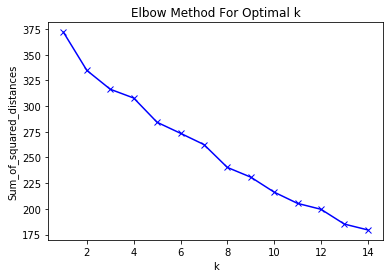

In [30]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
mms = MinMaxScaler()
mms.fit(toronto_grouped_clustering)
toronto_transformed = mms.transform(toronto_grouped_clustering)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()    

#### Around 7 clusters would be ideal

In [31]:
# set number of clusters
kclusters = 7

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 6, 0, 0, 0, 0, 0, 0, 6])

In [32]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_new

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6543,-79.3606,0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Restaurant,Theater,Farmers Market,Chocolate Shop
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6623,-79.3895,0,Coffee Shop,Sushi Restaurant,Discount Store,Sandwich Place,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop,Fried Chicken Joint
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3789,0,Clothing Store,Coffee Shop,Bubble Tea Shop,Japanese Restaurant,Italian Restaurant,Café,Middle Eastern Restaurant,Cosmetics Shop,Diner,Tea Room
3,M5C,Downtown Toronto,St. James Town,43.6515,-79.3754,0,Coffee Shop,Café,Cocktail Bar,Gastropub,American Restaurant,Restaurant,Hotel,Italian Restaurant,Lingerie Store,Department Store
4,M4E,East Toronto,The Beaches,43.6764,-79.293,6,Trail,Health Food Store,Pub,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop


### Let's visualize the resulting clusters !

In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining the  Clusters

#### Cluster 1

In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Restaurant,Theater,Farmers Market,Chocolate Shop
1,"Queen's Park, Ontario Provincial Government",0,Coffee Shop,Sushi Restaurant,Discount Store,Sandwich Place,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop,Fried Chicken Joint
2,"Garden District, Ryerson",0,Clothing Store,Coffee Shop,Bubble Tea Shop,Japanese Restaurant,Italian Restaurant,Café,Middle Eastern Restaurant,Cosmetics Shop,Diner,Tea Room
3,St. James Town,0,Coffee Shop,Café,Cocktail Bar,Gastropub,American Restaurant,Restaurant,Hotel,Italian Restaurant,Lingerie Store,Department Store
5,Berczy Park,0,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Bakery,Seafood Restaurant,Restaurant,Café,Clothing Store,Irish Pub
6,Central Bay Street,0,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Japanese Restaurant,Department Store,Salad Place,Burger Joint,Bubble Tea Shop,Indian Restaurant
7,Christie,0,Grocery Store,Café,Park,Coffee Shop,Nightclub,Candy Store,Baby Store,Italian Restaurant,Diner,Restaurant
8,"Richmond, Adelaide, King",0,Coffee Shop,Café,Restaurant,Gym,Deli / Bodega,Clothing Store,Hotel,Thai Restaurant,Sushi Restaurant,Concert Hall
10,"Harbourfront East, Union Station, Toronto Islands",0,Coffee Shop,Aquarium,Café,Hotel,Restaurant,Brewery,Sporting Goods Shop,Fried Chicken Joint,Scenic Lookout,Italian Restaurant
11,"Little Portugal, Trinity",0,Bar,Asian Restaurant,Café,Men's Store,Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Mac & Cheese Joint,Park,Korean Restaurant


#### Cluster 2

In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Rosedale,1,Park,Playground,Trail,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


#### Cluster 3

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Roselawn,2,Ice Cream Shop,Home Service,Garden,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio,Dim Sum Restaurant


#### Cluster 4

In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,"Moore Park, Summerhill East",3,Gym,Park,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


#### Cluster 5

In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Lawrence Park,4,Park,Swim School,Bus Line,Farmers Market,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


#### Cluster 6

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,"Forest Hill North & West, Forest Hill Road Park",5,Jewelry Store,Trail,Sushi Restaurant,Mexican Restaurant,Yoga Studio,Diner,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


#### Cluster 7

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,The Beaches,6,Trail,Health Food Store,Pub,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
9,"Dufferin, Dovercourt Village",6,Pharmacy,Bakery,Middle Eastern Restaurant,Café,Bar,Supermarket,Bank,Music Venue,Brewery,Pet Store
15,"India Bazaar, The Beaches West",6,Sandwich Place,Fast Food Restaurant,Gym,Pet Store,Brewery,Burrito Place,Restaurant,Pub,Pizza Place,Movie Theater
20,Davisville North,6,Gym,Hotel,Park,Food & Drink Shop,Sandwich Place,Department Store,Breakfast Spot,Gym / Fitness Center,Pizza Place,Convention Center
25,"Parkdale, Roncesvalles",6,Breakfast Spot,Gift Shop,Cuban Restaurant,Eastern European Restaurant,Dog Run,Italian Restaurant,Bar,Restaurant,Movie Theater,Bookstore
31,"Summerhill West, Rathnelly, South Hill, Forest...",6,Coffee Shop,Light Rail Station,Pub,Pizza Place,Bank,Bagel Shop,Restaurant,Fried Chicken Joint,Sports Bar,Supermarket
38,"Business reply mail Processing Centre, South C...",6,Yoga Studio,Auto Workshop,Park,Pizza Place,Restaurant,Butcher,Burrito Place,Skate Park,Brewery,Comic Shop
